---
title: "Sexism Detection"
author:
  - Francesco Baiocchi
  - Christian Di Buò
  - Leonardo Petrilli
date: "2025-01-14"
format:
  html:
    theme: cosmo
---


# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [ ]:
!pip install datasets --quiet
!pip install evaluate --quiet
!pip install simplejson --quiet
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 68.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import json
from tqdm import tqdm
import simplejson as sj
from pathlib import Path
from functools import reduce
import urllib
from collections import Counter
from typing import Dict, List, Callable, Tuple, Optional
import copy
import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd
import numpy as np
from scipy.special import softmax
import seaborn as sns

import tensorflow as tf
import keras
import torch

import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.downloader as gloader

from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from keras.metrics import F1Score, Precision, Recall
from keras.utils import plot_model

import transformers
from transformers import (
    AutoModelForSequenceClassification,
    TFAutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorWithPadding,
    Trainer,
    EarlyStoppingCallback,
)

import requests
import re
import datasets
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, auc

import warnings
warnings.filterwarnings('ignore')


In [ ]:
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def set_reproducibility(seed: int) -> None:
    """
    Fixes any possible source of randomness.

    :param seed: seed to ensure reproducibility (int)
    """
    keras.utils.set_random_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.config.experimental.enable_op_determinism()
    os.environ["TF_DETERMINISTIC_OPS"] = "1"  ### can make training slower


set_reproducibility(seed=42)

1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.


In [ ]:
url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%201/data/"

train_df = pd.read_json(url + "training.json").T
validation_df = pd.read_json(url + "validation.json").T
test_df = pd.read_json(url + "test.json").T

In [ ]:
print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {validation_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (6920, 11)
Validation set shape: (726, 11)
Test set shape: (312, 11)


3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".


In [ ]:
def determine_label(row: pd.Series) -> Optional[str]:
    """
    Converts soft labels into hard labels (strings).

    :param row: row of the dataset to convert (pd.Series)

    :return
        - string representing the hard label
    """
    num_yes = row["labels_task1"].count("YES")
    num_no = row["labels_task1"].count("NO")
    if num_yes == num_no:
        return None
    return "YES" if num_yes > num_no else "NO"


def corpus(df: pd.DataFrame, multilingual:bool = False) -> pd.DataFrame:
    """
    Converts soft labels into hard labels (int) and drops irrelevant rows/columns.

    :param df: dataset split to convert (pd.DataFrame)
    :param multilingual: whether to keep spanish tweets (bool)

    :return
        - refined dataset
    """
    df["hard_label_task1"] = df.apply(determine_label, axis=1)
    df = df.dropna(subset=["hard_label_task1"])
    if not multilingual:
      df = df[df["lang"] != "es"]
    df = df[["id_EXIST", "lang", "tweet", "hard_label_task1"]]
    df.loc[df["hard_label_task1"] == "YES", "hard_label_task1"] = 1
    df.loc[df["hard_label_task1"] == "NO", "hard_label_task1"] = 0
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
train_df = corpus(train_df)
validation_df = corpus(validation_df)
test_df = corpus(test_df)

In [ ]:
validation_df

,id_EXIST,lang,tweet,hard_label_task1
0,400001,en,"@Mike_Fabricant “You should smile more, love. ...",0
1,400002,en,@BBCWomansHour @LabWomenDec @EverydaySexism Sh...,1
2,400003,en,#everydaysexism Some man moving my suitcase in...,1
3,400004,en,@KolHue @OliverJia1014 lol gamergate the go to...,0
4,400005,en,@ShelfStoriesGBL To me this has the same negat...,0
...,...,...,...,...
153,400172,en,@leesu44 @elishabroadway @markbann57 @SeaeyesT...,1
154,400174,en,It is is impossible for a man to become a woma...,1
155,400175,en,If Gaga decided to sing 18 versions of Free Wo...,0
156,400176,en,This is your reminder that you can be child-fr...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In order to filter out emojis we used an up-to-date list of emoji data from Github.


In [ ]:
url = (
    "https://raw.githubusercontent.com/muan/unicode-emoji-json/main/data-by-emoji.json"
)
response = requests.get(url)
json_data = response.json()


emoji_list = list(json_data.keys())
regex_pattern = "|".join(re.escape(word) for word in emoji_list)

EMOJI_RE = re.compile(regex_pattern)
HASHTAG_RE = re.compile(r"\B\@(\w)+")
MENTIONS_RE = re.compile(r"\B\#(\w)+")
URLS_RE = re.compile(r"https?://\S*")
SPECIAL_CHAR_RE = re.compile(r"[^a-zA-Z]")

In [ ]:
def remove_emojis(text: str) -> str:
    """
    Removes emojis from the given text.

    :param text: text to be filtered (str)

    :return
        - cleaned text
    """
    return EMOJI_RE.sub(" ", text)


def remove_hashtags(text: str) -> str:
    """
    Removes hashtags from the given text.

    :param text: text to be filtered (str)

    :return
        - cleaned text
    """
    return HASHTAG_RE.sub(" ", text)


def remove_mentions(text: str) -> str:
    """
    Removes mentions from the given text.

    :param text: text to be filtered (str)

    :return
        - cleaned text
    """
    return MENTIONS_RE.sub(" ", text)


def remove_urls(text: str) -> str:
    """
    Removes URLs from the given text.

    :param text: text to be filtered (str)

    :return
        - cleaned text
    """
    return URLS_RE.sub(" ", text)


def remove_special_chars(text: str) -> str:
    """
    Removes special chars from the given text.

    :param text: text to be filtered (str)

    :return
        - cleaned text
    """
    return SPECIAL_CHAR_RE.sub(" ", text)


def lower(text: str) -> str:
    """
    Transforms given text to lower case.

    :param text: text to be filtered (str)

    :return
        - cleaned text
    """
    return text.lower()

Pipeline for the preprocessing of text.


In [ ]:
PREPROCESSING_PIPELINE = [
    remove_emojis,
    remove_hashtags,
    remove_mentions,
    remove_urls,
    remove_special_chars,
    lower,
]


def text_prepare(text: str, filter_methods: Optional[List[Callable[[str], str]]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).

    :param text: text to be processed (str)
    :param filter_methods: list of functions to apply (list)

    :return
        - pre-processed text
    """
    filter_methods = (
        filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    )
    return reduce(lambda txt, f: f(txt), filter_methods, text)

Sanity check on preprocessing pipeline.

In [ ]:
print("Pre-processing text...")

print(f"\n[Debug] Before:\n{train_df['tweet'][0]}\n")

# Replace each sentence with its pre-processed version
train_df["tweet"] = train_df["tweet"].apply(lambda txt: text_prepare(txt))

print(f"[Debug] After:\n{train_df['tweet'][0]}\n")


print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
Writing a uni essay in my local pub with a coffee. Random old man keeps asking me drunk questions when I'm trying to concentrate &amp; ends with "good luck, but you'll just end up getting married and not use it anyway". #EverydaySexism is alive and well 🙃

[Debug] After:
writing a uni essay in my local pub with a coffee  random old man keeps asking me drunk questions when i m trying to concentrate  amp  ends with  good luck  but you ll just end up getting married and not use it anyway     is alive and well  

Pre-processing completed!


We stored a copy of train, validation and test that we used later in the Transformer section.


In [ ]:
validation_df["tweet"] = validation_df["tweet"].apply(lambda txt: text_prepare(txt))
test_df["tweet"] = test_df["tweet"].apply(lambda txt: text_prepare(txt))

train_df.to_csv("train_cleaned.csv")
validation_df.to_csv("validation_cleaned.csv")
test_df.to_csv("test_cleaned.csv")

- **Perform lemmatization** to reduce words to their base form.

In [ ]:
def get_wordnet_key(pos_tag: str) -> str:
    """
    Converts pos_tag to the correct format.

    :param pos_tag: tag to be converted (str)

    :return
        - formatted tag
    """
    if pos_tag.startswith("J"):
        return wordnet.ADJ
    elif pos_tag.startswith("V"):
        return wordnet.VERB
    elif pos_tag.startswith("N"):
        return wordnet.NOUN
    elif pos_tag.startswith("R"):
        return wordnet.ADV
    else:
        return "n"


def tokenize_tweet(tweet: str) -> List[str]:
    """
    Applies tokenization and lemmatization to the given text.

    :param tweet: text to be tokenized (str)

    :return
        - tokenized and lemmatized tweet
    """
    lemmatizer = WordNetLemmatizer()
    tweet = word_tokenize(tweet)
    tweet = pos_tag(tweet)
    tweet = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) for word, tag in tweet]
    return tweet

In [ ]:
test_df["tweet"] = test_df["tweet"].apply(tokenize_tweet)
validation_df["tweet"] = validation_df["tweet"].apply(tokenize_tweet)

Sanity check on tokenizer.

In [ ]:
print("Tokenizing text...")

print(f"\n[Debug] Before:\n{train_df['tweet'][0]}\n")

# Lemmatize and tokenize each sentence
train_df["tweet"] = train_df["tweet"].apply(tokenize_tweet)

print(f"[Debug] After:\n{train_df['tweet'][0]}\n")


print("Tokenization completed!")

Tokenizing text...

[Debug] Before:
writing a uni essay in my local pub with a coffee  random old man keeps asking me drunk questions when i m trying to concentrate  amp  ends with  good luck  but you ll just end up getting married and not use it anyway     is alive and well  

[Debug] After:
['write', 'a', 'uni', 'essay', 'in', 'my', 'local', 'pub', 'with', 'a', 'coffee', 'random', 'old', 'man', 'keep', 'ask', 'me', 'drunk', 'question', 'when', 'i', 'm', 'try', 'to', 'concentrate', 'amp', 'end', 'with', 'good', 'luck', 'but', 'you', 'll', 'just', 'end', 'up', 'get', 'married', 'and', 'not', 'use', 'it', 'anyway', 'be', 'alive', 'and', 'well']

Tokenization completed!


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
def build_vocabulary(df: pd.DataFrame) -> Tuple[Dict[int, str], Dict[str, int], List[str]]:
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = {}
    word_to_idx = {}

    word_to_idx["PAD"] = 0
    idx_to_word[0] = "PAD"
    word_to_idx["UNK"] = 1
    idx_to_word[1] = "UNK"

    curr_idx = 2

    for sentence in tqdm(df["tweet"].values):
        for token in sentence:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [ ]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_df)
print(f"\n[Debug] Index -> Word vocabulary size: {len(idx_to_word)}")
print(f"[Debug] Word -> Index vocabulary size: {len(word_to_idx)}")
print(f"[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(20)]}")

100%|██████████| 2870/2870 [00:00<00:00, 146534.38it/s]


[Debug] Index -> Word vocabulary size: 8872
[Debug] Word -> Index vocabulary size: 8872
[Debug] Some words: [('PAD', 0), ('UNK', 1), ('write', 2), ('a', 3), ('uni', 4), ('essay', 5), ('in', 6), ('my', 7), ('local', 8), ('pub', 9), ('with', 10), ('coffee', 11), ('random', 12), ('old', 13), ('man', 14), ('keep', 15), ('ask', 16), ('me', 17), ('drunk', 18), ('question', 19)]


In [ ]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame
) -> None:
    """
    Performs sanity checks on the vocabularies.

    :param idx_to_word: word vocabulary to test (dict)
    :param word_to_idx: inverse word vocabulary to test (dict)
    :param word_listing: set of unique words to test (list)
    :param df: dataset to test (pd.DataFrame)
    """
    print("[Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("[Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("[Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    print("[Vocabulary Evaluation] Word_listing checking...")
    _, _, assert_word_listing = build_vocabulary(train_df)
    assert_valid_vocabulary = set(
        [token for tweet in train_df.tweet.values for token in tweet]
    )
    assert_valid_vocabulary.update(["PAD", "UNK"])
    assert set(assert_word_listing) == assert_valid_vocabulary

Sanity check on vocabulary.

In [ ]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("\nEvaluation completed!")

Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...


100%|██████████| 8872/8872 [00:00<00:00, 830343.97it/s]


[Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:00<00:00, 66044.78it/s]


[Vocabulary Evaluation] Word_listing checking...


100%|██████████| 2870/2870 [00:00<00:00, 25423.03it/s]



Evaluation completed!


In [ ]:
vocab_path = Path.cwd().joinpath("vocab.json")

print(f"Saving vocabulary to {vocab_path}")
with vocab_path.open(mode="w") as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to /content/vocab.json
Saving completed!


We chose **glove-wiki-gigaword** as a word embedding with a dimension of 300. This `embedding_dimension` ensures rich semantic representation without heavily increasing the computational cost.

In [ ]:
embedding_dimension = 300
embedding_model = gloader.load(f"glove-wiki-gigaword-{embedding_dimension}")

In [ ]:
def check_OOV_terms(
    embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: List[str]
) -> List[str]:
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = list(set(word_listing).difference(embedding_vocabulary))
    oov.remove('UNK')
    return oov

In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 906 (10.21%)


After the tokenization process, we stored a copy of validation and test split used in the Error Analysis section.

In [ ]:
validation_tokenized = copy.deepcopy(validation_df['tweet'])
test_tokenized = copy.deepcopy(test_df['tweet'])

In [ ]:
def put_unk(tweet: List[str]) -> List[str]:
    """
    Replaces tokens not present in the vocabulary with the "UNK" token.

    :param tweet: list of strings, where each string is a token from the tweet (list)

    :return
       - list of strings, where tokens not in the vocabulary have been replaced by "UNK"
    """
    tweet = [token if token in word_to_idx else "UNK" for token in tweet]
    return tweet

In [ ]:
validation_df["tweet"] = validation_df["tweet"].apply(put_unk)
test_df["tweet"] = test_df["tweet"].apply(put_unk)

We assigned a zero vector as the embedding of the PAD token since, in this way, it will be masked out by the embedding layer of the model.

In [ ]:
def build_embedding_matrix(
    embedding_model: gensim.models.keyedvectors.KeyedVectors,
    embedding_dimension: int,
    word_to_idx: Dict[str, int],
    vocab_size: int
) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: dimension of the embedding space (int)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        if word == "PAD":
            continue
        else:
            try:
                embedding_vector = embedding_model[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(
                    low=-0.05, high=0.05, size=embedding_dimension
                )

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

Check of the embedding matrix shape.

In [ ]:
# Testing
embedding_dimension = 300
embedding_matrix = build_embedding_matrix(
    embedding_model, embedding_dimension, word_to_idx, len(word_to_idx)
)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 8872/8872 [00:00<00:00, 258821.94it/s]

Embedding matrix shape: (8872, 300)


In [ ]:
max_train_length = max(len(tweet) for tweet in train_df["tweet"])
max_validation_length = max(len(tweet) for tweet in validation_df["tweet"])
max_test_length = max(len(tweet) for tweet in test_df["tweet"])
max_sequence_lenght = max(max_train_length, max_validation_length, max_test_length)

print(f"Max sequence lenght in train set: {max_train_length}")
print(f"Max sequence lenght in validation set: {max_validation_length}")
print(f"Max sequence lenght in test set: {max_test_length}")
print(f"Max sequence lenght: {max_sequence_lenght}")

Max sequence lenght in train set: 62
Max sequence lenght in validation set: 55
Max sequence lenght in test set: 61
Max sequence lenght: 62


In [ ]:
def pad_tweet(tweet: List[str]) -> List[str]:
    """
    Pads a tweet to a fixed length.

    :param tweet: tweet to be padded (list)

    :return
        - padded tweet
    """
    i = len(tweet)
    while i < max_sequence_lenght:
        tweet.append(idx_to_word[0])
        i = i + 1
    return tweet

In [ ]:

train_df["tweet"] = train_df["tweet"].apply(pad_tweet)
validation_df["tweet"] = validation_df["tweet"].apply(pad_tweet)
test_df["tweet"] = test_df["tweet"].apply(pad_tweet)

Sanity check on padded text.

In [ ]:
def assert_padding(df: pd.DataFrame) -> None:
    """
    Ensures that the padding has been applied correctly.

    :param df: dataset to test (pd.DataFrame)
    """
    print("[Debug] Padding checking...")
    for tweet in df["tweet"]:
        assert len(tweet) == max_sequence_lenght
    print("Padding checked!")


assert_padding(train_df)
assert_padding(validation_df)
assert_padding(test_df)

[Debug] Padding checking...
Padding checked!
[Debug] Padding checking...
Padding checked!
[Debug] Padding checking...
Padding checked!


Numerical conversion of tokens to feed them to the model.

In [ ]:
def word_to_num(tweet: List[str]) -> List[int]:
    """
    Converts words in a tweet to their corresponding indices.

    :param tweet: list of words to convert (List[str])

    :return
        - converted tweet
    """
    tweet = [word_to_idx[word] for word in tweet]
    return tweet

In [ ]:
train_df["tweet"] = train_df["tweet"].apply(word_to_num)
validation_df["tweet"] = validation_df["tweet"].apply(word_to_num)
test_df["tweet"] = test_df["tweet"].apply(word_to_num)

train_df

,id_EXIST,lang,tweet,hard_label_task1
0,200002,en,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 11, 12, 13, 14...",1
1,200003,en,"[40, 42, 38, 21, 45, 46, 47, 48, 49, 50, 51, 5...",1
2,200006,en,"[63, 24, 3, 64, 21, 65, 66, 67, 68, 24, 69, 70...",1
3,200007,en,"[83, 84, 85, 86, 87, 88, 30, 89, 31, 90, 91, 3...",1
4,200008,en,"[95, 24, 58, 96, 97, 98, 56, 99, 24, 100, 101,...",0
...,...,...,...,...
2865,203256,en,"[975, 207, 1120, 125, 334, 597, 65, 1150, 53, ...",1
2866,203257,en,"[97, 65, 42, 3, 326, 67, 350, 3491, 10, 251, 2...",1
2867,203258,en,"[693, 17, 427, 38, 777, 31, 35, 243, 42, 1217,...",1
2868,203259,en,"[207, 133, 31, 56, 77, 3, 2275, 8870, 0, 0, 0,...",1


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

We prepared the data by converting everything to a NumPy array as required by the Keras fit function.


In [ ]:
def format_data(
    sentences: pd.Series,
    labels: pd.Series
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reshapes and casts sentences and labels.

    :param sentences: sentences to be casted (pd.Series)
    :param labels: labels to be casted and reshaped (pd.Series)

    :return
        - sentences casted to np.ndarray
        - labels casted to np.ndarray and reshaped to (-1, 1)
    """

    sentences = np.array(list(sentences))
    labels = np.array(list(labels))
    labels = np.expand_dims(labels, axis=1)
    return sentences, labels

In [ ]:
train_sentences, train_labels = format_data(
    train_df["tweet"], train_df["hard_label_task1"]
)
validation_sentences, validation_labels = format_data(
    validation_df["tweet"], validation_df["hard_label_task1"]
)
test_sentences, test_labels = format_data(test_df["tweet"], test_df["hard_label_task1"])

We used `to_categorical` to convert train and validation labels into one-hot encoded format because we used Softmax as the last layer of our model. This conversion was necessary to compute macro metrics during training. Without this step, using a single-neuron output with a sigmoid activation function, Keras would have computed the metrics only for the positive class.

In [ ]:
categorical_train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=2)
categorical_validation_labels = tf.keras.utils.to_categorical(
    validation_labels, num_classes=2
)

The function below builds a Bidirectional LSTM model with an optional additional LSTM layer. The `add_lstm` parameter is a boolean flag that acts as the following:

* if `add_lstm=False`, only the first Bidirectional LSTM layer is used, making the model simpler. (**Baseline**)
* if `add_lstm=True`, a second Bidirectional LSTM layer is added after the first, providing a deeper model. (**Model 1**)

 Since the pre-trained embeddings already capture semantic relationships well, we adopted frozen embeddings by setting `trainable=False`, drastically reducing the number of trainable parameters and so preventing overfitting.



In [ ]:
def get_model(lstm_units: int = 64, add_lstm: bool = False, vocab_size: int = len(word_listing)) -> keras.Model:
    """
    Builds a Bidirectional LSTM model layer by layer.

    :param lstm_units: number of LSMT cells (int)
    :param add_lstm: whether or not to put an additional LSTM layer (bool)
    :param vocab_size: size of the vocabulary (int)

    :return
        - Bidirectional LSTM model
    """
    input = Input(shape=(max_sequence_lenght,))

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        mask_zero=True,  # automatically masks padding tokens
        name="encoder_embedding",
        trainable=False,
    )
    embedding = embedding_layer(input)
    bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=add_lstm))(embedding)
    bi_lstm2 = (
        Bidirectional(LSTM(lstm_units, return_sequences=False))(bi_lstm)
        if add_lstm
        else bi_lstm
    )
    dense_output = Dense(units=2, activation="softmax")(bi_lstm2)
    model_name = "Model_1" if add_lstm else "Baseline"
    model = keras.Model(input, dense_output, name=model_name)

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
        metrics=[
            F1Score(average="macro", threshold=0.5),
            Precision(name="precision_zero", thresholds=0.5, class_id=0),
            Precision(name="precision_one", thresholds=0.5, class_id=1),
            Recall(name="recall_zero", thresholds=0.5, class_id=0),
            Recall(name="recall_one", thresholds=0.5, class_id=1),
        ],
    )
    return model

In [ ]:
baseline = get_model()
plot_model(
    baseline, to_file="baseline_summary.png", show_shapes=True, dpi=60, show_dtype=True
)
baseline.summary()

Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 62)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 62, 300)        │      2,661,600 │ input_layer[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 62)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │        186,880 │ encoder_embedding[0][… │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │            258 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,848,738 (10.87 MB)

 Trainable params: 187,138 (731.01 KB)

 Non-trainable params: 2,661,600 (10.15 MB)

In [ ]:
model_1 = get_model(add_lstm=True)
plot_model(
    model_1, to_file="model_1_summary.png", show_shapes=True, dpi=60, show_dtype=True
)
model_1.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 62)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 62, 300)        │      2,661,600 │ input_layer_1[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 62)             │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 62, 128)        │        186,880 │ encoder_embedding[0][… │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 128)            │         98,816 │ bidirectional_1[0][0], │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            258 │ bidirectional_2[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,947,554 (11.24 MB)

 Trainable params: 285,954 (1.09 MB)

 Non-trainable params: 2,661,600 (10.15 MB)

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

### Train **all** models on the train set.

In [ ]:
def train_loop(
    model: keras.Model,
    batch_size: int = 32,
    epochs: int = 50,
    patience: int = 10,
    sample_weights: Optional[List[float]] = None
) -> Tuple[keras.Model, float, float, float, List[float]]:
    """
    Performs training and computes metrics on the validation set.

    :param model: model to train (keras.Model)
    :param batch_size: size of batches (int)
    :param epochs: number of epochs (int)
    :param patience: patience for early stopping (int)
    :param sample_weights: weights for the samples (list)

    :return
        - trained model (keras.Model)
        - best macro f1 score on validation (float)
        - best macro precision on validation (float)
        - best macro recall on validation(float)
        - loss history (list)
    """
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=patience, verbose=0, restore_best_weights=True
    )

    history = model.fit(
        train_sentences,
        categorical_train_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(validation_sentences, categorical_validation_labels),
        callbacks=[early_stopping],
        sample_weight=sample_weights,
        verbose=0,
    )

    best_epoch = np.argmin(history.history["val_loss"])
    best_f1 = history.history["val_f1_score"][best_epoch]

    # Compute macro averages (precision and recall)
    best_precision = (
        history.history["val_precision_zero"][best_epoch]
        + history.history["val_precision_one"][best_epoch]
    ) / 2
    best_recall = (
        history.history["val_recall_zero"][best_epoch]
        + history.history["val_recall_one"][best_epoch]
    ) / 2

    return model, best_f1, best_precision, best_recall, history.history["loss"]

The choice between Baseline and Model 1 is performed by averaging the validation F1-score over three seeds. Then we chose as `best_model` the one with the highest performance.

In [ ]:
# train loop on 3 seeds
seeds = [1, 2, 3]
baseline_models = {}
model1_models = {}

for seed in seeds:
    print(f"Seed: {seed}")
    set_reproducibility(seed)

    baseline_model = get_model(add_lstm=False)
    baseline_model, best_f1, best_precision, best_recall, loss_bsl = train_loop(
        baseline_model
    )
    baseline_models[best_f1] = (baseline_model, seed, loss_bsl)
    print(
        f"\tBaseline f1_score: {best_f1:.3f}, precision {best_precision:.3f}, recall {best_recall:.3f}"
    )

    model_1 = get_model(add_lstm=True)
    model_1, best_f1, best_precision, best_recall, loss_m1 = train_loop(model_1)
    model1_models[best_f1] = (model_1, seed, loss_m1)
    print(
        f"\n\tModel_1 f1_score: {best_f1:.3f}, precision {best_precision:.3f}, recall {best_recall:.3f}"
    )
    print("=" * 80)

Seed: 1
	Baseline f1_score: 0.804, precision 0.809, recall 0.801

	Model_1 f1_score: 0.800, precision 0.800, recall 0.799
Seed: 2
	Baseline f1_score: 0.842, precision 0.852, recall 0.838

	Model_1 f1_score: 0.829, precision 0.838, recall 0.825
Seed: 3
	Baseline f1_score: 0.793, precision 0.794, recall 0.792

	Model_1 f1_score: 0.785, precision 0.789, recall 0.783


After the training we plotted the validation losses to explore the model's variability over three seeds.  

In [ ]:
def plot_loss(loss: List[float], name: str, ax: matplotlib.axes.Axes) -> None:
    """
    Plots loss curves over three seeds.

    :param loss: losses to plot (list)
    :param name: name of the model to be displayed (str)
    :param ax: axis to plot on (matplotlib.axes.Axes)
    """
    for i in range(len(loss)):
        ax.plot(loss[i], label=f"seed {i+1}")

    ax.set_title(f"Model {name}")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()

As we can see from the plots below the training is pretty stable, meaning that the choice of the seed seems to not affect so much model's performance.

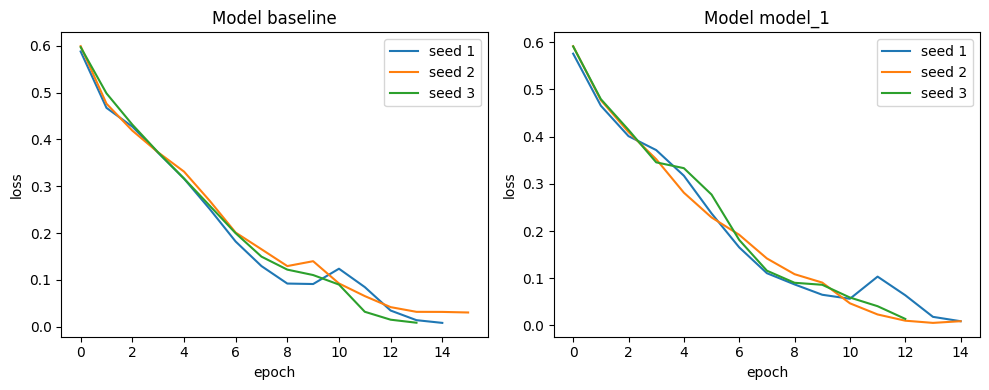

In [ ]:
model_1_losses = [el[2] for el in model1_models.values()]
baseline_losses = [el[2] for el in baseline_models.values()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_loss(baseline_losses, "baseline", ax[0])
plot_loss(model_1_losses, "model_1", ax[1])

plt.tight_layout()
plt.show()

In [ ]:
def show_results(model_dict: Dict[float, Tuple[keras.Model, int, List[float]]]) -> Tuple[float, float, float]:
    """
    Shows the results of a model as the average over the three seeds.

    :param model_dict: dictionary of models' performances (dict)

    :return
        - best f1 score on the validation set (float)
        - average f1 score (float)
        - f1 score on the test set (float)
    """

    average_f1 = np.mean([f1 for f1 in model_dict.keys()])
    best_f1 = max(model_dict.keys())
    average_f1 = np.mean(list(model_dict.keys()))
    std_f1 = np.std(list(model_dict.keys()))
    print(
        f"{model_dict[best_f1][0].name} validation average f1_score: {average_f1:.3f}, std {std_f1:.3f}\n"
    )

    test_pred = model_dict[best_f1][0].predict(test_sentences, verbose=0)
    f1_test = f1_score(np.argmax(test_pred, axis=1), test_labels, average="macro")

    print(f"Best {model_dict[best_f1][0].name} test f1_score: {f1_test:.3f}")
    print("=" * 80, "\n")

    return best_f1, average_f1, f1_test

### Pick the best performing model according to the observed validation set performance

In [ ]:
best_f1_baseline, average_f1_baseline, f1_test_baseline = show_results(baseline_models)
best_f1_model_1, average_f1_model_1, f1_test_model_1 = show_results(model1_models)

if average_f1_baseline > average_f1_model_1:
    best_model, best_seed, _ = baseline_models[best_f1_baseline]
    best_f1_validation = best_f1_baseline
    best_f1_test = f1_test_baseline

else:
    best_model, best_seed, _ = model1_models[best_f1_model_1]
    best_f1_validation = best_f1_model_1
    best_f1_test = f1_test_model_1

print(f"Best model: {best_model.name}, validation f1_score: {best_f1_validation:.3f}, test f1_score: {best_f1_test:.3f}, seed: {best_seed}")

Baseline validation average f1_score: 0.813, std 0.021

Best Baseline test f1_score: 0.748

Model_1 validation average f1_score: 0.805, std 0.018

Best Model_1 test f1_score: 0.763

Best model: Baseline, validation f1_score: 0.842, test f1_score: 0.748, seed: 2


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

1. **Load the Tokenizer and Model**


In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-hate"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
data = datasets.load_dataset(
    "csv",
    data_files={
        "train": "train_cleaned.csv",
        "validation": "validation_cleaned.csv",
        "test": "test_cleaned.csv",
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

In [ ]:
def preprocess_text(texts: datasets.formatting.formatting.LazyBatch) -> transformers.tokenization_utils_base.BatchEncoding:
    """
    Applies tokenization to the given dataset.

    :param texts: dataset to tokenize (LazyBatch)

    :return
        - tokenized dataset (BatchEncoding)
    """
    return tokenizer(texts["tweet"], truncation=True)

In [ ]:
print("Tokenizing text...")

print(f"\n[Debug] Before:\n{data['train']['tweet'][0]}\n")

# Lemmatize and tokenize each sentence
data = data.map(preprocess_text, batched=True)

print(f"\n[Debug] After:\n{data['train'][0]['input_ids']}\n")

print(tokenizer.decode(data["train"][0]["input_ids"]))

print("\nTokenization completed!")

Tokenizing text...

[Debug] Before:
writing a uni essay in my local pub with a coffee  random old man keeps asking me drunk questions when i m trying to concentrate  amp  ends with  good luck  but you ll just end up getting married and not use it anyway     is alive and well  



Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]


[Debug] After:
[0, 13293, 10, 542, 118, 14700, 11, 127, 400, 8881, 19, 10, 3895, 1437, 9624, 793, 313, 4719, 1996, 162, 10789, 1142, 77, 939, 475, 667, 7, 14410, 1437, 28127, 1437, 3587, 19, 1437, 205, 6620, 1437, 53, 47, 19385, 95, 253, 62, 562, 2997, 8, 45, 304, 24, 6992, 1437, 1437, 1437, 1437, 16, 4299, 8, 157, 1437, 1437, 2]

<s>writing a uni essay in my local pub with a coffee  random old man keeps asking me drunk questions when i m trying to concentrate  amp  ends with  good luck  but you ll just end up getting married and not use it anyway     is alive and well  </s>

Tokenization completed!


In [ ]:
data = data.rename_column("hard_label_task1", "label")
print(data["train"])

Dataset({
    features: ['Unnamed: 0', 'id_EXIST', 'lang', 'tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2870
})


In [ ]:
def compute_metrics(output_info: List[np.ndarray]) -> Dict[str, float]:
    """
    Computes accuracy and macro f1 score.

    :param output_info: predictions and labels to compute metrics (list)

    :return
        - dictionary of metrics (dict)
    """
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="loss",
    greater_is_better=False,
    seed=best_seed,
    logging_strategy='epoch'
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Performances before fine-tuning.

In [ ]:
test_info = trainer.predict(data["test"])
y_pred_transformer, y_true = test_info.predictions, test_info.label_ids
test_metrics = compute_metrics([y_pred_transformer, y_true])
print(
    f'Transformer test f1_score {test_metrics["f1"]:.4f}, accuracy {test_metrics["acc"]:.4f}'
)

Transformer test f1_score 0.6234, accuracy 0.6853


3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Acc
1,0.447400,0.439996,0.003300,0.843920,0.854430
2,0.316700,0.482837,0.003300,0.851224,0.860759
3,0.199000,0.715282,0.003300,0.850172,0.860759
4,0.116600,0.837943,0.003300,0.843920,0.854430


TrainOutput(global_step=1436, training_loss=0.26992921908917866, metrics={'train_runtime': 268.9611, 'train_samples_per_second': 106.707, 'train_steps_per_second': 13.348, 'total_flos': 403615442254920.0, 'train_loss': 0.26992921908917866, 'epoch': 4.0})

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
test_info = trainer.predict(data["test"])
y_pred_transformer, y_true = test_info.predictions, test_info.label_ids
test_metrics = compute_metrics([y_pred_transformer, y_true])
print(
    f'Transformer test f1_score {test_metrics["f1"]:.4f}, accuracy {test_metrics["acc"]:.4f}'
)

Transformer test f1_score 0.8451, accuracy 0.8497


We decided to freeze all the layers except for the last three layers of the encoder and the final classifier because we noticed that the model tends to overfit from the very early epochs.

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-hate"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
for name, param in model.named_parameters():
  if 'classifier' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'encoder.layer.9' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.433100,0.423892,0.810649,0.822785
2,0.376400,0.397606,0.830348,0.841772
3,0.341400,0.408738,0.818027,0.829114
4,0.309400,0.374536,0.869313,0.873418
5,0.261800,0.441950,0.883385,0.886076
6,0.238800,0.555244,0.876130,0.879747
7,0.207300,0.587575,0.882905,0.886076


TrainOutput(global_step=2513, training_loss=0.30974551230087916, metrics={'train_runtime': 199.3457, 'train_samples_per_second': 143.971, 'train_steps_per_second': 18.009, 'total_flos': 706339100332440.0, 'train_loss': 0.30974551230087916, 'epoch': 7.0})

After freezing the lower layers the overfitting is reduced, enabling the model to train for more epochs. Eventually the model has improved a bit on the test set.

In [ ]:
test_info = trainer.predict(data["test"])
y_pred_transformer, y_true = test_info.predictions, test_info.label_ids
test_metrics = compute_metrics([y_pred_transformer, y_true])
print(
    f'Transformer test f1_score {test_metrics["f1"]:.4f}, accuracy {test_metrics["acc"]:.4f}'
)

Transformer test f1_score 0.8588, accuracy 0.8601


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



**Impact of Seed Initialization on Error Analysis**


As a general premise, we noticed that the error analysis is highly dependent on the choice of the initial global seed due to its role in fixing the random vectors associated with UNK tokens. Given the large number of UNK tokens, this heavily influences model performance, causing significant variations in metrics like macro F1 (from about 0.7 to 0.78) and error patterns. With different seeds, entirely different patterns of errors emerge, highlighting the instability caused by small validation and test sets.

To address this a larger dataset could mitigate these issues and provide more reliable insights.

## Performances

In [ ]:
# get predictions as probability distributions
model_test_preds_soft = best_model.predict(test_sentences)
transformer_preds_soft = softmax(torch.tensor(y_pred_transformer), axis=-1)

# get predictions as integer labels (0 -> not sexist, 1 -> sexist)
model_test_preds_hard = np.argmax(model_test_preds_soft, axis=1)
transformer_preds_hard = np.argmax(transformer_preds_soft, axis=-1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Utility function to make plots




In [ ]:
def plot_cm(y_pred: np.ndarray, y_true: np.ndarray, model_name: str, axis: np.ndarray) -> None:
    """
    Plots both confusion matrix and classification report of the given model.

    :param y_pred: model predictions (np.ndarray)
    :param y_true: true labels (np.ndarray)
    :param model_name: name of the model to display (str)
    :param axis: axis to plot on (np.ndarray)
    """
    cr = classification_report(y_true, y_pred, output_dict=True)
    cr = pd.DataFrame(cr).T
    sns.heatmap(cr.iloc[:, :].astype(float), annot=True, fmt=".2f",
                cmap="Blues", cbar=False,
                xticklabels=cr.columns, yticklabels=cr.index,
                linewidths=0.5, linecolor="gray", ax=axis[0])
    axis[0].set_facecolor("white")
    axis[0].set_title(f'Classification Report: {model_name}', fontsize=14, weight="bold")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", colorbar=False, ax=axis[1])
    axis[1].set_facecolor("white")
    axis[1].set_title(f'Confusion Matrix: {model_name}', fontsize=14, weight="bold")
    axis[1].set_xlabel("Predicted Labels", fontsize=12)
    axis[1].set_ylabel("True Labels", fontsize=12)

    for ax in axis:
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)


def plot_precision_recall(y_preds: np.ndarray, y_true: np.ndarray, model_name: str, ax: matplotlib.axes.Axes) -> None:
    """
    Plots precison-recall curve of the given model.

    :param y_preds: model predictions (np.ndarray)
    :param y_true: true labels (np.ndarray)
    :param model_name: name of the model to display (str)
    :param ax: axis to plot on (matplotlib.axes.Axes)
    """
    # Precision recall curve
    y_preds = y_preds[:,1]
    precision, recall, _ = precision_recall_curve(y_true, y_preds)
    prevalence_pos_label = np.sum(y_true) / len(y_true)
    disp = PrecisionRecallDisplay(precision=precision,recall=recall,prevalence_pos_label=prevalence_pos_label)
    auc_score = auc(recall,precision)
    disp.plot(ax,name=f'Model (AUC = {auc_score:.2f}',plot_chance_level=True)
    ax.fill_between(recall, precision, alpha=0.2)
    ax.text(
      0.6,
      0.2,
      f"AUC = {auc_score:.2f}",
      fontsize=12,
      color="blue",
      bbox=dict(facecolor="white", alpha=0.7),
    )
    ax.set_xlabel("False Positive Rate (FPR)",fontsize=12)
    ax.set_ylabel("True Positive Rate (TPR)",fontsize=12)
    ax.set_title(f"{model_name} Curve",fontsize=14, weight="bold")
    ax.legend()

As we can see from the classification reports below there's a performance gap between the Custom Model and the Transformer. The majority of the errors made by the Custom Model occur on label 1, while the Transformer seems to be more balanced as pointed out by the confusion matrices.

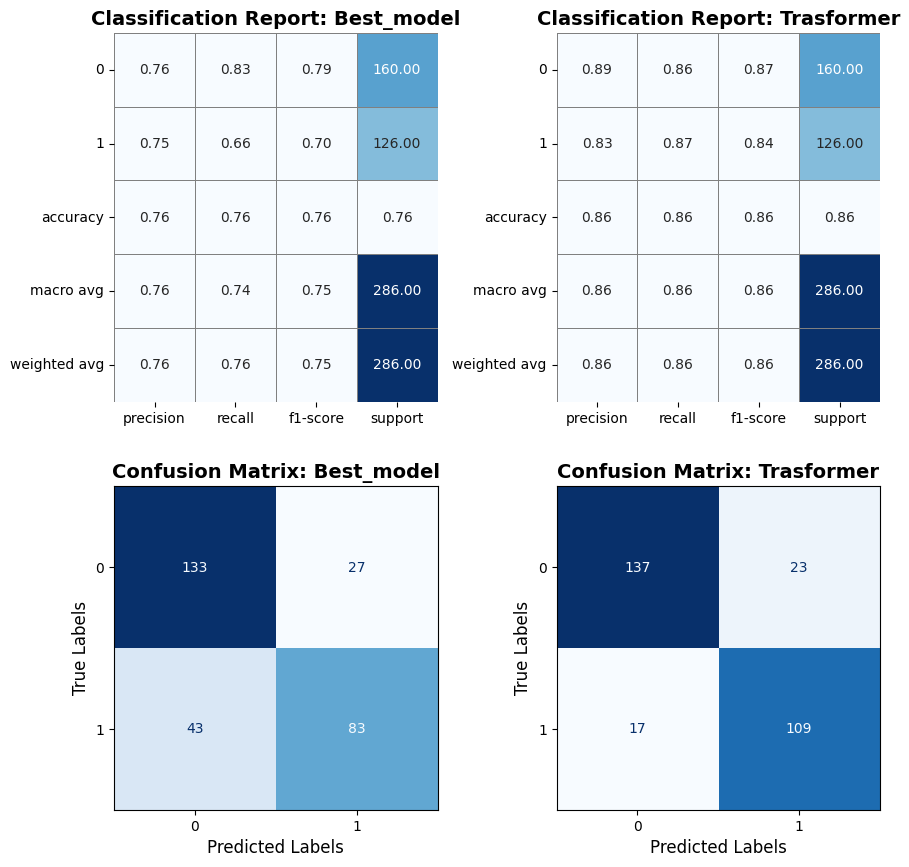

In [ ]:
# plots
fig, ax = plt.subplots(2,2,figsize=(9,9))
plot_cm(model_test_preds_hard, test_labels, "Best_model",(ax[0][0],ax[1][0]))
plot_cm(transformer_preds_hard, test_labels, "Trasformer",(ax[0][1],ax[1][1]))
plt.tight_layout()

As we can see from the Precision-Recall curves on label 1 the Transformer achieves a higher AUC score (0.88) compared to the Custom Model (0.80), indicating better overall precision and recall balance across thresholds.

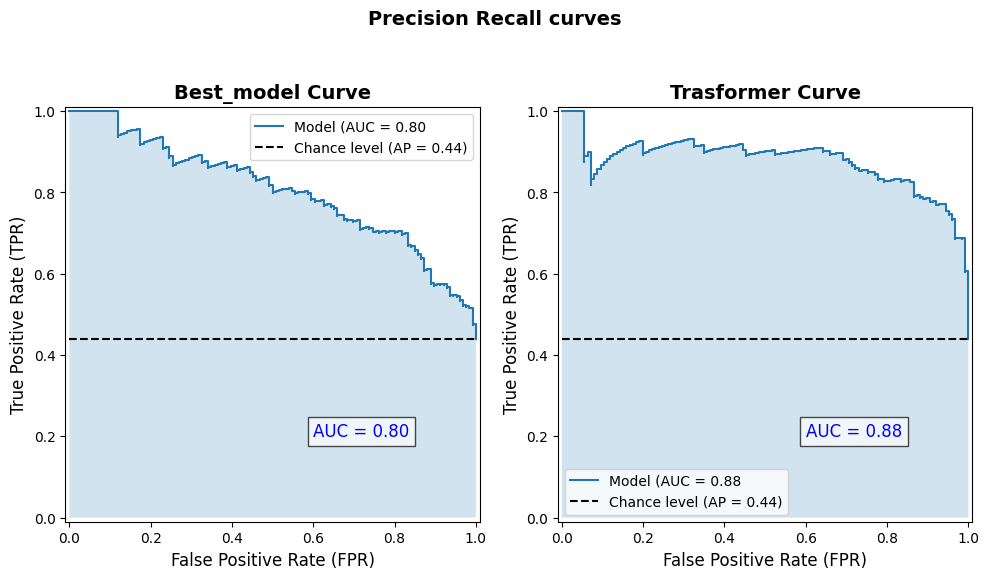

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
fig.suptitle('Precision Recall curves',fontsize=14, weight="bold")
plot_precision_recall(model_test_preds_soft, test_labels, "Best_model", ax[0])
plot_precision_recall(transformer_preds_soft, test_labels, "Trasformer", ax[1])
plt.tight_layout()
plt.show()

Utility function used for decoding sentences to display.

In [ ]:
def custom_decode(sentences: np.ndarray) -> List[List[str]]:
    """
    Converts back token ids of the custom model to words.

    :param sentences: sentences to decode (np.ndarray)

    :return
        - decoded sentences (list)
    """
    decoded_sentences = []
    for sentence in sentences:
        decoded_sentence = []
        for word in sentence:
            if word != 0:
                decoded_sentence.append(idx_to_word[word])
        decoded_sentences.append(decoded_sentence)
    return decoded_sentences

In [ ]:
decoded_test = custom_decode(test_sentences)

## Dataset Imbalance

Let's show how the labels are distributed across the dataset.

In [ ]:
def plot_data_distribution(df: pd.DataFrame, ax: matplotlib.axes.Axes, title: str) -> None:
    """
    Shows the distribution of a dataset split.

    :param df: split of the dataset (pd.DataFrame)
    :param ax: axis to plot on (matplotlib.axes.Axes)
    :param title: title of the plot (str)
    """
    label_1 = len(df[df["hard_label_task1"] == 1])
    label_0 = len(df[df["hard_label_task1"] == 0])
    bar_colors = ["#6baed6", "#2171b5"]
    bars = ax.bar(["label_1", "label_0"], [label_1, label_0], color=bar_colors)
    percentages = [(label_1 / len(df))*100, (label_0 / len(df))*100]
    for bar, percentage in zip(bars, percentages):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{percentage:.2f}%",
            ha="center",
            va="bottom",
        )
    ax.set_title(title)
    ax.set_ylabel("label count")

All the three splits seem to have similar label distribution, even though the train set is slightly more imbalanced. Perhaps this imbalance could be the reason why the Custom Model tends to have a bias towards non sexism as previously shown by the confusion matrix.

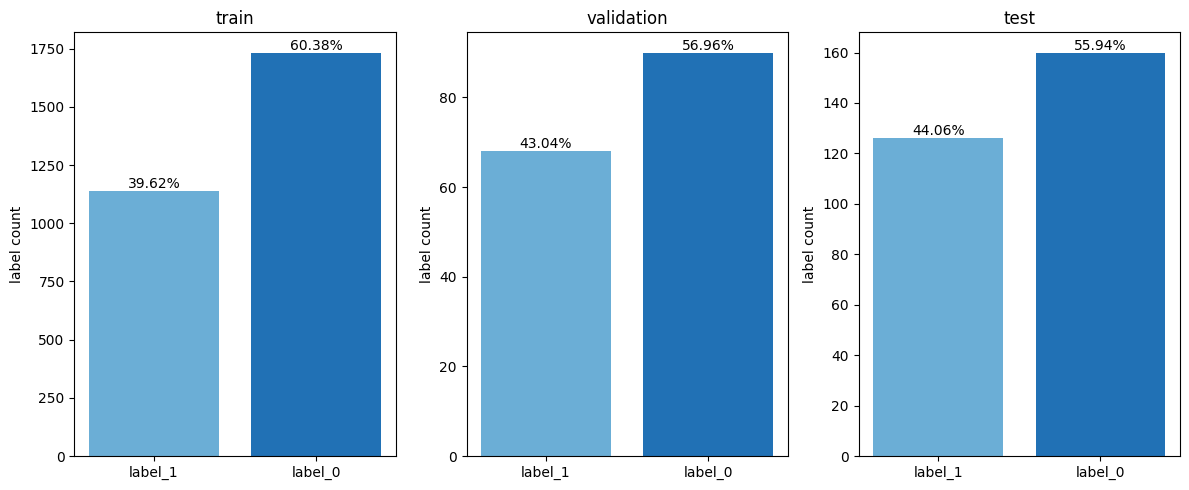

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
plot_data_distribution(train_df, ax[0], "train")
plot_data_distribution(validation_df, ax[1], "validation")
plot_data_distribution(test_df, ax[2], "test")
plt.tight_layout()
plt.show()

## Sentence-level analysis

Let's now see which are the common errors at sentence level.

In [ ]:
def display_common_errors(model_preds: np.ndarray, transformer_preds: np.ndarray, true_labels: np.ndarray, sentences: List[List[str]]) -> None:
  """
  Shows the common errors between the custom model and the transformer.

  :param model_preds: predictions of the custom model (np.ndarray)
  :param transformer_preds: predictions of the transformer (np.ndarray)
  :param true_labels: true labels (np.ndarray)
  :param sentences: input sentences (list)
  """
  common_errors = pd.DataFrame(columns=["sentence", "true_label", "model_prediction",'transformer_pred'])
  transformer_errors = pd.DataFrame(columns=["sentence", "true_label", "model_prediction",'transformer_pred','diff_pred'])
  model_errors = pd.DataFrame(columns=["sentence", "true_label", "model_prediction",'transformer_pred','diff_pred'])
  sentences = sentences.apply(lambda x: copy.deepcopy(x))


  model_hards = np.argmax(model_preds, axis=1)
  transformer_hards = np.argmax(transformer_preds, axis=1)

  for i in range(len(true_labels)):
    if true_labels[i][0] != transformer_hards[i]:
      if model_hards[i] == transformer_hards[i]:
        common_errors.loc[len(common_errors)] = [
                  " ".join(sentences[i]),
                  true_labels[i][0],
                  model_preds[i][true_labels[i][0]],
                  transformer_preds[i][true_labels[i][0]],
              ]
      else:
        transformer_errors.loc[len(transformer_errors)] = [
                  " ".join(sentences[i]),
                  true_labels[i][0],
                  model_preds[i][true_labels[i][0]],
                  transformer_preds[i][true_labels[i][0]],
                  abs(model_preds[i][true_labels[i][0]] - transformer_preds[i][true_labels[i][0]]),
              ]
    elif model_hards[i] != transformer_hards[i]:
      for j in range(len(sentences[i])):
        if sentences[i][j] in oov_terms or sentences[i][j] not in word_listing:
          if sentences[i][j] in oov_terms:
            sentences[i][j] = f"<span style='color:red'>{sentences[i][j]}</span>"
          else:
            sentences[i][j] = f"<span style='color:blue'>{sentences[i][j]}</span>"

      model_errors.loc[len(model_errors)] = [
                " ".join(sentences[i]),
                true_labels[i][0],
                model_preds[i][true_labels[i][0]],
                transformer_preds[i][true_labels[i][0]],
                abs(model_preds[i][true_labels[i][0]] - transformer_preds[i][true_labels[i][0]]),
          ]

  common_errors = common_errors.sort_values(by='true_label', ascending=False)
  transformer_errors = transformer_errors.sort_values(by='diff_pred', ascending=False)
  model_errors = model_errors.sort_values(by='diff_pred', ascending=False)

  return common_errors, transformer_errors, model_errors

Below we display the sentences that both the Custom Model and the Tranformer got wrong along with the corresponding prediction values. The prediction value represents the probability that the model assigns to the true label, i.e smaller values imply larger errors made by the model.

In [ ]:
common_errors, transformer_errors, model_errors = display_common_errors(model_test_preds_soft, transformer_preds_soft, test_labels, test_tokenized)
print(f'Number of common errors between the Custom Model and the Transformer: {len(common_errors)}')
common_errors = common_errors.style.set_properties(**{'text-align':'left'})
display(common_errors)

Number of common errors between the Custom Model and the Transformer: 30


,sentence,true_label,model_prediction,transformer_pred
1,that gold digger be nice but the picture and set up for them be elite pinwork be like the revealing of the mona lisa always a work of art,1,0.045073,0.109728
2,dear fan can we not harass talented actor of color stop be racist douche nozzle this be why we can t have nice thing moses be a badass inquisitor and y all can t handle her badassary,1,0.284516,0.038928
4,call to clean up parliament s laddish culture after mp s porn shame via,1,0.271655,0.365000
9,i don t need a man to tell me what to stand up for thank you,1,0.314866,0.255073
8,go weak rn play the guitar manspreading i be on my knee,1,0.044828,0.229011
7,mansplaining the concept of a pee drawer to my partner who want me,1,0.332612,0.196164
13,cyborg politics be the struggle for language and the struggle against perfect communication against the one code that translate all mean perfectly the central dogma of phallogocentrism,1,0.018916,0.012902
12,have i miss something or have phallocentrism become the late cult,1,0.315829,0.036020
10,why bother go to mar if life there be just go to be more of the same toxic sexism racism and bigotry the same horrible oppression unfairness and inequality that make earth a living hell for so many,1,0.058804,0.308408
20,i pack my hubby case when we be go to a wedding in england tell him to pop his underpants in get to england he put his kilt outfit on and everyone discover what a true scot doesn t wear under his kilt if i don t do it it doesn t get do men,1,0.056732,0.182320


Here we display the sentences that **only** the **Transformer** got wrong, along with the absolute differences between prediction values. The sentences are sorted by these differences.

In [ ]:
print(f'Number of Transformer-only errors: {len(transformer_errors)}')
transformer_errors = transformer_errors.style.set_properties(**{'text-align':'left'})
display(transformer_errors)

Number of Transformer-only errors: 10


,sentence,true_label,model_prediction,transformer_pred,diff_pred
5,dude look like a lady aerosmith,1,0.936352,0.188096,0.748256
6,stay on penis masturbate the penis forever,0,0.830019,0.092392,0.737627
3,well let me ask for the guy do you ever just grab your testicle because you can,0,0.823763,0.152067,0.671696
0,i mean i do but wouldn t it be fun to get gangbanged together,0,0.980279,0.325955,0.654325
1,appreciate be include along with on the uvalde gunman s history of cyber gender harassment regrettably unshocking,0,0.638995,0.007495,0.631501
7,it s in the teaxass code book of penis envy idiot that it s gun over everything sad thing be it s spread and the more we try to stop it the faster it spread like the diseased idiot that support it,0,0.838803,0.217703,0.621100
2,how do we reach a point where blonks be have the audacity to talk about yoongis rap do y all see who you stan be y all ok your girl can t write can t deliver can t come close to bts s lyricism tf be y all get brave for fashion deal,0,0.594202,0.019369,0.574833
4,stop say i say this cu she have short hair some of her gay look come from blonde ponytail era know ur herstory,1,0.856455,0.330240,0.526215
8,sharia law in the religion of islam allows abortion before the th montha for rape incest mental physical health or life of mother be at risk after the th month abortion allow only to save the life of the mother,0,0.505552,0.284134,0.221419
9,isw publish the fake crap of any of the map they be just a front for the u state department they be fake news victoria nuland be the woman directly involve in the armed overthrow of the ukraine government in,0,0.538044,0.371504,0.166539


Conversely the sentences below represent the errors made **only** by the **Custom Model**. Additionally we have highlighted the UNK terms in blue and the OOV in red, showing that many of these words are closely related to sexism. Probably such words, which are highly informative for this task, caused the Custom Model to fail on those sentences.

In [ ]:
print(f'Number of Custom Model-only errors: {len(model_errors)}')
model_errors = model_errors.style.set_properties(**{'text-align':'left'})
display(model_errors)

Number of Custom Model-only errors: 40


,sentence,true_label,model_prediction,transformer_pred,diff_pred
29,sound like the typa nigga to let his bos sodomize him cause the job come with perk stfu keep that dick in ya mouth nd stay way the fuck out there wherever u nd that ignorant as comment be think of,1,0.073411,0.987215,0.913804
9,y all be husband and wife and best friend you guy have so much fun it s awesome you keep each other laughing and smile,0,0.079544,0.990332,0.910788
32,never know you all share tits how do we stop be pal again yeah,1,0.079930,0.972010,0.892079
28,der i literally take it last night slutbag,1,0.059965,0.949125,0.889161
10,wait till ur husband mess up u gon na love the scouser death threat,1,0.086108,0.975064,0.888955
21,eat out both hole and then slide my dick in you and pound you till you squirt,1,0.118759,0.984013,0.865254
1,suika get gangbanged to death,1,0.113801,0.971719,0.857918
38,yo i swear sagittarius men and woman be the funny,0,0.089753,0.922790,0.833037
4,the violent antifeminism of a far right movement that see principally a vessel for breed a new white generation express itself in a fixation on a return to traditional gender role worth every minute to read take min out of your sun,1,0.050172,0.864687,0.814515
37,you don t know who invent womanism huh okay risk skin cancer i guess best of luck to you,1,0.201679,0.990023,0.788343


Let’s now analyze potential patterns of error in the model’s predictions. We will start by plotting the length of the sentences that were incorrectly classified, this analysis can help us identify whether the model struggles with sentences of specific lengths.

In [ ]:
def plot_len_sentences(
    model_predictions: np.ndarray,
    true_labels: np.ndarray,
    sentences: List[List[str]],
    model_name: str) -> None:
    """
    Plots the length of the wrong classified sentences for each label and calculates correlation.

    :param model_predictions: predictions of the model (np.ndarray)
    :param true_labels: true labels (np.ndarray)
    :param sentences: input sentences (list)
    :param model_name: name of the model for the plot title (str)
    """
    df = pd.DataFrame({"sentences": list(sentences)})
    df["true_label"] = true_labels
    df["pred_label"] = model_predictions.astype(int)

    df_wrong = df[df["true_label"] != df["pred_label"]]
    len_sentences_wrong = Counter([len(row) for row in df_wrong["sentences"]])
    len_sentences = Counter([len(row) for row in df["sentences"]])

    all_lengths, all_counts = zip(*len_sentences.items())
    wrong_lengths, wrong_counts = zip(*len_sentences_wrong.items())

    plt.bar(wrong_lengths, wrong_counts, color="tab:blue", label="Wrong Sentences")
    plt.bar(all_lengths, all_counts, alpha=0.3, color="tab:blue", label="All Sentences")
    plt.title(f"Length of {model_name} wrong sentences")
    plt.xlabel("Sentence Length")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    wrong_dict = dict(len_sentences_wrong)
    all_dict = dict(len_sentences)

    lengths = list(set(all_dict.keys()).union(set(wrong_dict.keys())))
    wrong_counts_aligned = [wrong_dict.get(length, 0) for length in lengths]
    all_counts_aligned = [all_dict.get(length, 0) for length in lengths]

    correlation = np.corrcoef(wrong_counts_aligned, all_counts_aligned)[0, 1]
    print(f"Correlation between wrong sentence lengths and total lengths: {correlation:.2f}")

Comparing the length distribution of the missclassified sentences with that of all sentences we noticed a quite high correlation between the two. This means that sentence length does not significantly influence the predictions of either the Custom Model or the Transformer.

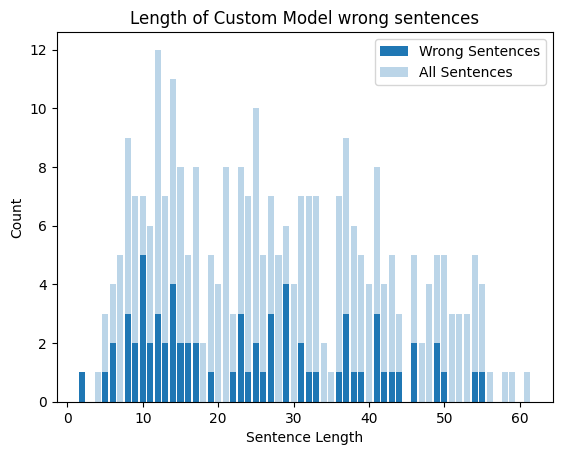

Correlation between wrong sentence lengths and total lengths: 0.71


In [ ]:
plot_len_sentences(model_test_preds_hard, test_labels, decoded_test, 'Custom Model')

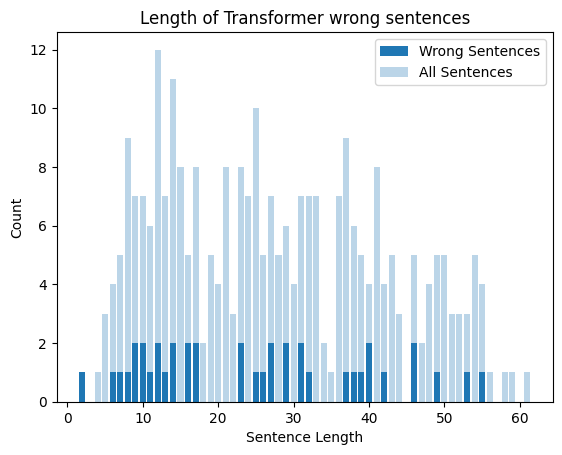

Correlation between wrong sentence lengths and total lengths: 0.50


In [ ]:
plot_len_sentences(transformer_preds_hard, test_labels, decoded_test, 'Transformer')

## Word-level analysis

Since it looks like there are no clear error patterns at sentence level, we will delve into a more fine-grained analysis: a word-level analysis. This analysis will help us understand whether certain types of words systematically affect the model's predictions.


In [ ]:
def plot_unk_stats(model_predictions: np.ndarray,
                   true_labels: np.ndarray,
                   sentences: List[List[str]]) -> Tuple[List[str],List[str]]:
  '''
  Displays the statistic releated to the UNK token.

  :param model_predictions: predictions of the model (np.ndarray)
  :param true_labels: true labels (np.ndarray)
  :param sentences: input sentences (list)
  '''

  def update_stats(df:pd.DataFrame) -> None:
    all_words = Counter(
      word if word not in oov_terms else 'OOV' for row in df["sentences"] for word in row
    )
    df_wrong = df[df['true_label'] != df['pred_label']]
    wrongest_words = Counter(
      word if word not in oov_terms else 'OOV' for row in df_wrong["sentences"] for word in row
    )

    count_total_unk, count_total_oov = all_words['UNK'], all_words['OOV']
    count_wrong_unk, count_wrong_oov = wrongest_words['UNK'], wrongest_words['OOV']

    unk_per_sentences = np.mean([sum([1 for word in sentence if word=='UNK']) for sentence in df["sentences"]])
    unk_per_wrong_sentences = np.mean([sum([1 for word in sentence if word=='UNK']) for sentence in df_wrong["sentences"]])
    unk_stats.loc[len(unk_stats)] = [len(df), len(df_wrong), count_total_unk, count_wrong_unk, count_total_oov, count_wrong_oov]


  column_names = pd.MultiIndex.from_product([['Sentences', 'UNK', 'OOV'], ['Total', 'Wrong']])
  unk_stats = pd.DataFrame(columns = column_names, dtype = int)
  df = pd.DataFrame({"sentences": list(sentences)})
  df["true_label"] = true_labels
  df["pred_label"] = model_predictions

  df_0 = df[df["true_label"] == 0]
  df_1 = df[df["true_label"] == 1]
  update_stats(df_0)
  update_stats(df_1)
  print('Statistics of UNK and OOV terms of Custom Model\n')
  display(unk_stats)


The table below shows statistics related to the presence of **UNK** and **OOV** tokens in the sentences, distinguishing between all sentences (total) and those incorrectly classified. Although there are differences in the counts, the proportion of **UNK** and **OOV** tokens in wrong predictions does not suggest a strong influence on the Custom Model's errors. Specifically:


*   **UNK** tokens appear frequently in both total and wrong sentences, but their distribution does not seem to correlate with misclassifications.

*   **OOV** tokens are relatively rare overall, but a large number of them (11 out of 20) appear in misclassified sentences with label 1. Indeed, as we have seen in the earlier analysis section, these terms are closely related to sexism and are important for the task.

In [ ]:
plot_unk_stats(model_test_preds_hard, test_labels, decoded_test)

Statistics of UNK and OOV terms of Custom Model



Sentences         UNK         OOV      
      Total Wrong Total Wrong Total Wrong
0       160    27   340    35    10     0
1       126    43   218    60    20    11

Since UNK terms do not appear to be correlated with the Custom Model's errors, we will now focus on analyzing the frequency of the most common terms, including OOV terms. This analysis aims to identify the words most strongly correlated with the model's misclassifications.

In [ ]:
def plot_wrong_word(model_predictions: np.ndarray,
                    true_labels: np.ndarray,
                    sentences: List[List[str]],
                    model_name: str,
                    top_wrongest: int = 20) -> None:
    """
    Shows the most frequent words in wrong classified sentences.

    :param model_predictions: predictions of the model (np.ndarray)
    :param true_labels: true labels (np.ndarray)
    :param model_name: name of the model for the plot title (str)
    :param sentences: input sentences (list)
    """
    def find_wrongest(df: pd.DataFrame, label: int, ax: matplotlib.axes.Axes) -> None:
        df = df[df["true_label"] == label]
        all_words = Counter(
            word for row in df["sentences"] for word in row if word not in stop_words
        )
        df_wrong = df[df['true_label'] != df['pred_label']]
        wrongest_words = Counter(
            word for row in df_wrong["sentences"] for word in row if word not in stop_words
        )

        wr_words, wr_counts = zip(*wrongest_words.most_common(top_wrongest)[:0:-1])
        ax.barh(wr_words, wr_counts, color="skyblue", label='Wrong Sentences')
        counts = [all_words[word] for word in wr_words]
        ax.barh(wr_words, counts, color="skyblue",alpha=0.4, label='All Sentences')
        ax.set_title(f"Wrongest words in label {label}")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()

    stop_words = list(stopwords.words("english")) + list(stopwords.words("spanish")) + ['n', 'ser']
    df = pd.DataFrame({"sentences": list(sentences)})
    df["true_label"] = true_labels
    df["pred_label"] = model_predictions.astype(int)

    fig, axs = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(f'{model_name} charts', weight="bold")
    find_wrongest(df, 0, axs[0])
    find_wrongest(df, 1, axs[1])
    plt.tight_layout()
    plt.show()

Each of the following chart highlights the top words that contributed to the model's errors for the respective label. Common stop words (e.g., "the", "and", "is") are removed to focus on more meaningful terms that might influence the model's predictions.

For each word, the chart shows:
*  Darker Bars: Frequency of the word in misclassified sentences.
*  Lighter Bars (Transparent): Overall frequency of the word in all sentences of the given label.





Here are the key findings from the **Custom Model** charts:


*   **Label 0**: As shown in the left chart, most of the words are closely related to sexism (e.g., '**woman**', '**sex**', '**feminism**', '**harassment**'). In particular, the word '**woman**' is not only the most frequently misclassified word but also the one with the highest misclassification rate compared to its overall occurrence in sentences.

*   **Label 1**: As shown in the right chart, there is no single word particularly correlated with misclassifications for label 1, for instance 'woman' is by far the most frequent word in all sentences, it has a relatively low proportion of misclassifications compared to its total occurrences.

**Final observations:**

This analysis suggests that the model may exhibit a bias, associating the word '**woman**' strongly with sexism, regardless of the actual context. This bias could be influencing the model’s overall performance.

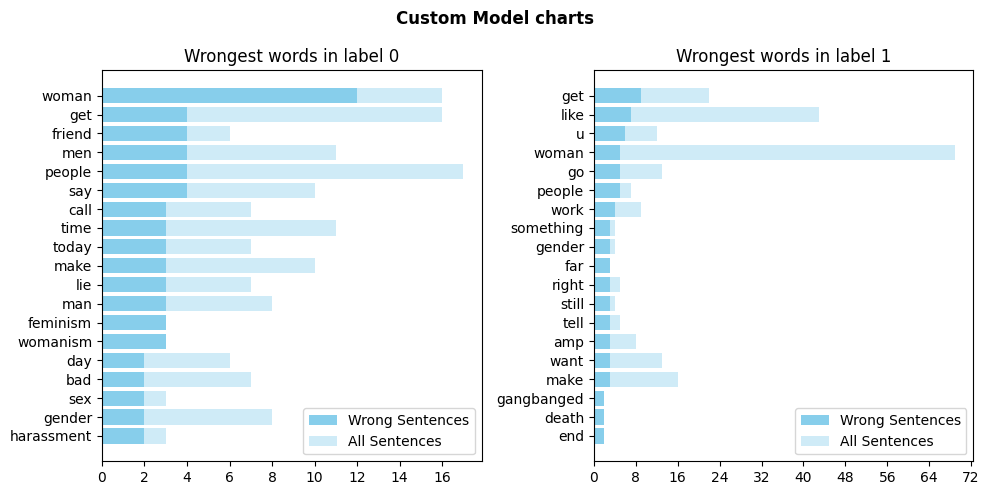

In [ ]:
plot_wrong_word(model_test_preds_hard, test_labels, decoded_test, 'Custom Model')

Here are the key findings from the **Transformer** charts:

**Label 0**: Similar to the Custom Model, most of the words are closely related to sexism. However, in the Transformer Model, the word '**woman**' is again the most frequently misclassified word but with a slightly lower misclassification rate compared to its overall occurrence in sentences, suggesting the Transformer may handle this word marginally better than the Custom Model.

**Label 1**:  Unlike Label 0, there is no clear word strongly correlated with misclassifications. Words such as '**like**', '**look**', '**get**' contribute the most to errors, but they are general-purpose words rather than terms specifically related to sexism. This indicates that, for label 1, the Transformer’s errors are not driven by any specific thematic words. The word '**woman**' does not appear in the chart for label 1, meaning that it does not play an important role in the misclassifications for this label.


**Final Observations:**

This analysis reveals that the Transformer exhibits the same bias as the Custom Model, associating the word 'woman' strongly with sexism, regardless of the actual context.

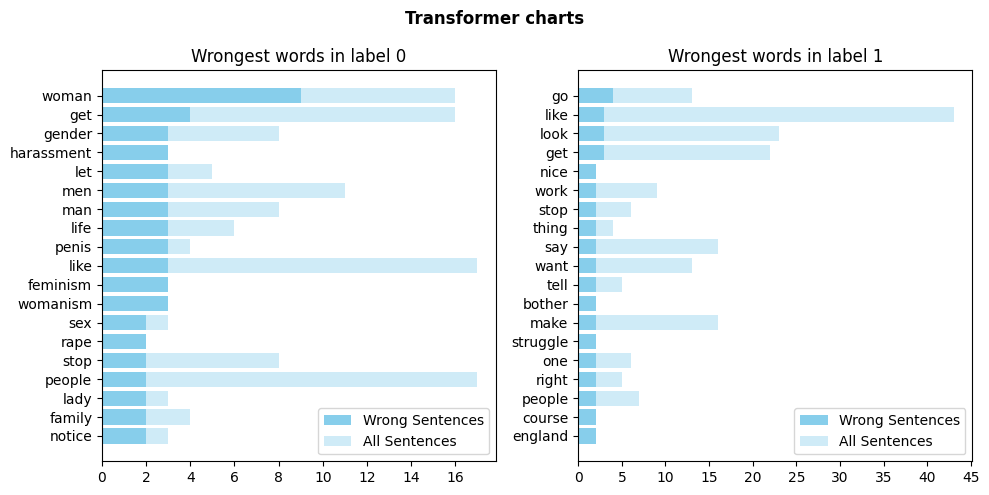

In [ ]:
plot_wrong_word(transformer_preds_hard, test_labels, decoded_test, 'Transformer')

This consistent pattern across both models suggests that the bias may not originate from the models themselves but rather from the dataset.

If the dataset overrepresents the word '**woman**' in contexts related to sexism, the models are likely to learn an inaccurate association between the word and sexist content. This imbalance might cause the models to incorrectly classify sentences containing '**woman**', even when the context is neutral.


### Correlation Analysis: Woman, OOV and UNK tokens

After identifying error patterns involving the word **'woman'**, **OOV tokens**, and **UNK tokens**, we aim to test their significance by calculating their correlation with misclassification errors.
This analysis will help determine whether these factors are strongly associated with errors or if their impact is less meaningful. Understanding these correlations is crucial for validating the observed patterns.

In [ ]:
def plot_correlation(
                     labels: np.ndarray,
                     predictions: np.ndarray,
                     sentences: List[List[str]],
                     model_name: str,
                     oov_terms: List[str] = []) -> None:
  """
  Computes and plots correlations to highlight relevant patterns.

  :param labels: true labels (np.ndarray)
  :param predictions: predictions of the model (np.ndarray)
  :param sentences: input sentences (list)
  :param model_name: name of the model for the plot title (str)
  :param oov_terms: list of OOV terms (list)
  """
  def compute_correlation(label: int, ax: matplotlib.axes.Axes) -> None:

    report = pd.DataFrame(
    columns=[
        "woman",
        "oov",
        "unk",
        "is_wrong",
      ]
    )

    for enum, sentence in enumerate(sentences):

      if labels[enum] == label:

        unk_count = 0
        oov_count = 0
        woman_count = 0

        for word in sentence:
          if word == "UNK":
              unk_count += 1
          if word in oov_terms:
              oov_count += 1
          if word == 'woman':
              woman_count += 1

        is_wrong = 1
        if labels[enum] == predictions[enum]:
          is_wrong = 0

        report.loc[len(report)] = [
            woman_count,
            oov_count,
            unk_count,
            is_wrong,
        ]

    if model_name == 'Transformer':
      report = report[['woman','is_wrong']]

    corr = report.corr()
    sns.heatmap(corr, cmap="Blues", annot=True, ax = ax,vmin=0,vmax=1);
    ax.set_title(f'Label {label}')

  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  fig.suptitle(f'{model_name} Correlation Matrices', weight="bold")
  compute_correlation(0, ax[0])
  compute_correlation(1, ax[1])
  plt.show()

The correlation matrix confirms the pattern seen earlier: the word '**woman**' is positively correlated with errors in label 0 and negatively correlated with errors in label 1. This shows that the Custom Model tends to associate '**woman**' with sexism in label 0 and is less likely to misclassify sentences with **'woman'** in label 1.

On the other hand, UNK and OOV terms show no significant correlation with errors.

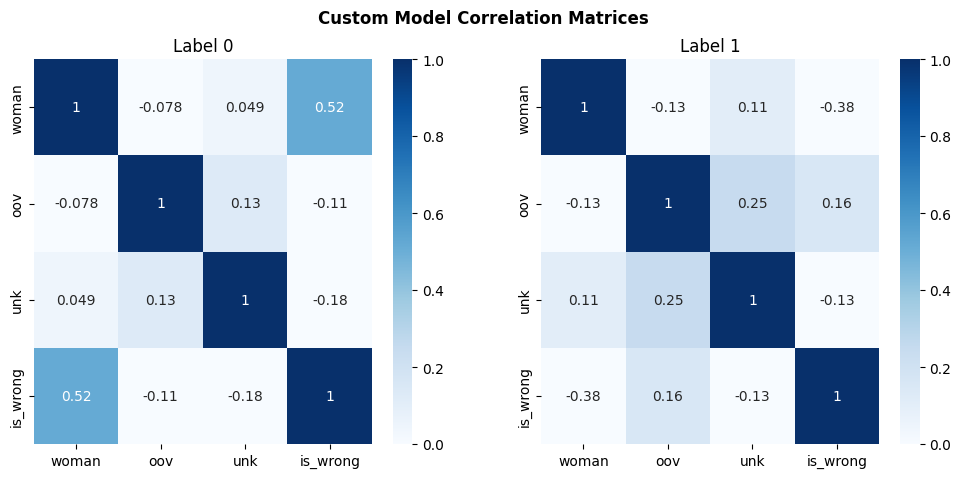

In [ ]:
plot_correlation(test_labels, model_test_preds_hard, decoded_test,'Custom Model', oov_terms)

The correlation matrix for the Transformer shows similar results to the Custom Model, with a slightly lower positive correlation with errors in label 0.

It does not include UNK and OOV terms because the Transformer model processes the input directly using its own tokenization. This structural difference simplifies the analysis, focusing only on the word 'woman' and its correlation with errors.

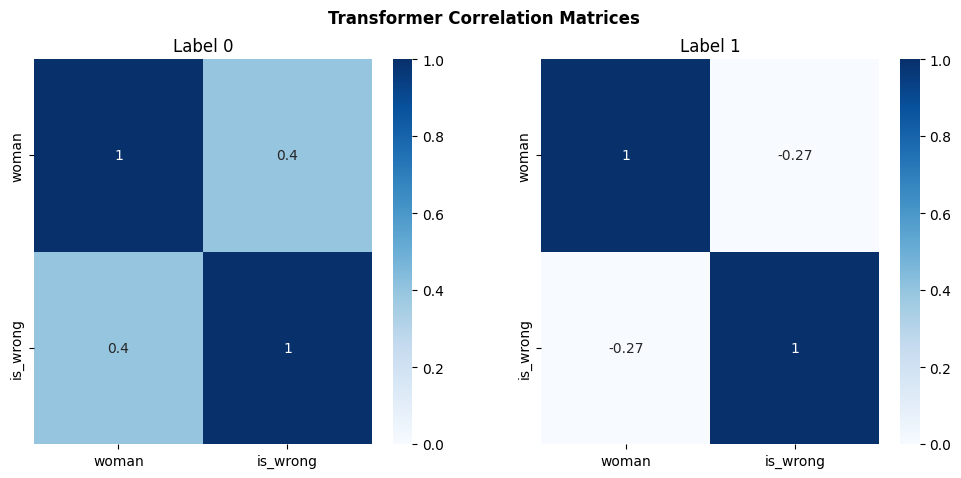

In [ ]:
plot_correlation(test_labels, transformer_preds_hard, decoded_test, 'Transformer')

In [ ]:
# get OOV terms in wrong sentences of label 1
wrong_oov_1 = [word  for i, sentence in enumerate(decoded_test) for word in sentence if test_labels[i] != model_test_preds_hard[i] and test_labels[i] == 1 and word in oov_terms]
print(f'OOV terms in misclassified sentences of label 1: {set(wrong_oov_1)}')

OOV terms in misclassified sentences of label 1: {'slutbag', 'gangbanged', 'phallogocentrism', 'phallocentrism', 'manspreading', 'mansplaining'}


Actually we think that the weak correlation between OOV terms and misclassified sentences on label 1 is due to the fact that, as we have seen from the previous analyses, the most informative OOV terms were exclusively found in the misclassified sentences of label 1. So we will try to recompute the correlation focusing only on those terms (the ones in the list above).

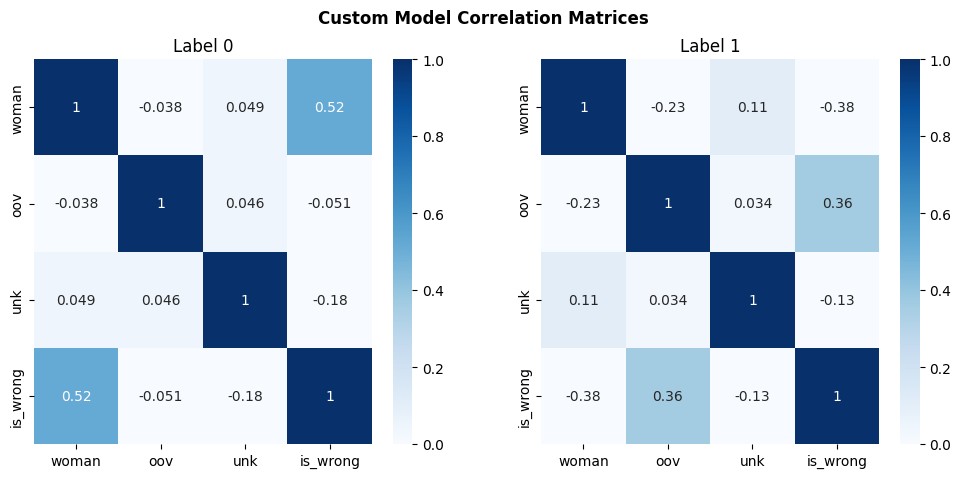

In [ ]:
plot_correlation(test_labels, model_test_preds_hard, decoded_test,'Custom Model', wrong_oov_1)

As expected the correlation between OOV terms and misclassified sentences has increased, meaning that these terms are a source of error for label 1 sentences.

Given the two main error patterns identified in the previous analyses, we propose the following solutions:

*   **'woman' pattern**: addressing this issue would require refining the dataset, providing more diverse contextual examples, and/or applying bias mitigation strategies during training.
*  **OOV pattern**:  a possible solution could be trying to assign to these terms an embedding close to semantically similar words already present in our vocabulary, or implementing subword tokenization techniques.

## Mulitilingual Model

This section explores Spanish tweets using three different models: the two previously discussed models and a multilingual transformer. Since the test split of the dataset does not include Spanish tweets, we decided to evaluate performance on the validation set.

### Custom Model

In [ ]:
url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%201/data/"

train_df = pd.read_json(url + "training.json").T
validation_df = pd.read_json(url + "validation.json").T

In [ ]:
train_df = corpus(train_df,multilingual=True)
validation_df = corpus(validation_df,multilingual=True)

In [ ]:
validation_df

,id_EXIST,lang,tweet,hard_label_task1
0,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,1
1,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,0
2,300004,es,Also mientras les decia eso la señalaba y deci...,1
3,300005,es,"And all people killed, attacked, harassed by ...",0
4,300006,es,On this #WorldPressFreedomDay I’m thinking of ...,0
...,...,...,...,...
643,400172,en,@leesu44 @elishabroadway @markbann57 @SeaeyesT...,1
644,400174,en,It is is impossible for a man to become a woma...,1
645,400175,en,If Gaga decided to sing 18 versions of Free Wo...,0
646,400176,en,This is your reminder that you can be child-fr...,0


Once we introduced Spanish tweets into the dataset, the labels became more balanced than before, especially in the validation set.



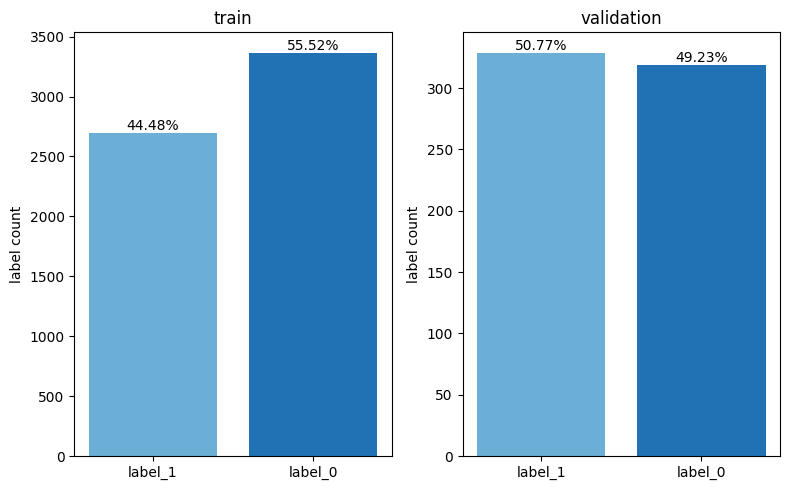

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
plot_data_distribution(train_df, ax[0], "train")
plot_data_distribution(validation_df, ax[1], "validation")
plt.tight_layout()
plt.show()

In [ ]:
print(f'Number of english tweet in train set: {len(train_df[train_df["lang"] == "en"])}')
print(f'Number of spanish tweet in train set: {len(train_df[train_df["lang"] == "es"])}\n')

print(f'Number of english tweet in validation set: {len(validation_df[validation_df["lang"] == "en"])}')
print(f'Number of spanish tweet in validation set: {len(validation_df[validation_df["lang"] == "es"])}')

Number of english tweet in train set: 2870
Number of spanish tweet in train set: 3194

Number of english tweet in validation set: 158
Number of spanish tweet in validation set: 490


In [ ]:
PREPROCESSING_PIPELINE = [
    remove_emojis,
    remove_hashtags,
    remove_mentions,
    remove_urls,
    remove_special_chars,
    lower,
]
train_df["tweet"] = train_df["tweet"].apply(lambda txt: text_prepare(txt))
validation_df["tweet"] = validation_df["tweet"].apply(lambda txt: text_prepare(txt))

In [ ]:
train_df.to_csv('train_multilingual.csv')
validation_df.to_csv('validation_multilingual.csv')

For the lemmatization part, we could not use the WordNet Lemmatizer as it is designed exclusively for English. Therefore, we decided to adopt the **Spacy Lemmatizer**, which supports both English and Spanish sentences.

In [ ]:
nlp_en = spacy.load("en_core_web_sm")
nlp_es = spacy.load("es_core_news_sm")

def tokenize_tweet(row: pd.Series) -> pd.Series:
    """
    Tokenizes and lemmatizes the given tweet based on the specified language.

    :param row: row of a DataFrame (pd.Series)

    :return: tokenized and lemmatized tweet (List[str])
    """
    nlp = nlp_en if row['lang'] == "en" else nlp_es
    doc = nlp(row['tweet'])
    row['tweet'] = [token.lemma_ for token in doc if not token.is_space]
    return row

train_df = train_df.apply(tokenize_tweet,axis=1)
validation_df = validation_df.apply(tokenize_tweet,axis=1)

In [ ]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_df)
print(f"\n[Debug] Index -> Word vocabulary size: {len(idx_to_word)}")
print(f"[Debug] Word -> Index vocabulary size: {len(word_to_idx)}")
print(f"[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(20)]}")

100%|██████████| 6064/6064 [00:00<00:00, 118996.81it/s]


[Debug] Index -> Word vocabulary size: 19132
[Debug] Word -> Index vocabulary size: 19132
[Debug] Some words: [('PAD', 0), ('UNK', 1), ('ignorar', 2), ('al', 3), ('otro', 4), ('ser', 5), ('uno', 6), ('capullo', 7), ('el', 8), ('problema', 9), ('con', 10), ('este', 11), ('youtuber', 12), ('denunciar', 13), ('acoso', 14), ('cuando', 15), ('no', 16), ('afectar', 17), ('a', 18), ('gente', 19)]


We decided to use **GloVe-Twitter**, a specialized version of GloVe, because it includes a larger vocabulary compared to the previously used version, particularly providing embeddings for many Spanish words.

In [ ]:
embedding_dimension = 200
embedding_model = gloader.load(f"glove-twitter-{embedding_dimension}")

In [ ]:
embedding_matrix = build_embedding_matrix(
    embedding_model, embedding_dimension, word_to_idx, len(word_to_idx)
)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 19132/19132 [00:00<00:00, 130848.23it/s]

Embedding matrix shape: (19132, 200)


In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 3495 (18.27%)


In [ ]:
validation_df["tweet"] = validation_df["tweet"].apply(put_unk)

In [ ]:
max_train_length = max(len(tweet) for tweet in train_df["tweet"])
max_validation_length = max(len(tweet) for tweet in validation_df["tweet"])
max_sequence_lenght = max(max_train_length, max_validation_length)

print(f"Max sequence lenght in train set: {max_train_length}")
print(f"Max sequence lenght in validation set: {max_validation_length}")
print(f"Max sequence lenght: {max_sequence_lenght}")

Max sequence lenght in train set: 62
Max sequence lenght in validation set: 61
Max sequence lenght: 62


In [ ]:
train_df["tweet"] = train_df["tweet"].apply(pad_tweet)
validation_df["tweet"] = validation_df["tweet"].apply(pad_tweet)

In [ ]:
train_df["tweet"] = train_df["tweet"].apply(word_to_num)
validation_df["tweet"] = validation_df["tweet"].apply(word_to_num)

In [ ]:
train_sentences, train_labels = format_data(
    train_df["tweet"], train_df["hard_label_task1"]
)
validation_sentences, validation_labels = format_data(
    validation_df["tweet"], validation_df["hard_label_task1"]
)

In [ ]:
categorical_train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=2)
categorical_validation_labels = tf.keras.utils.to_categorical(
    validation_labels, num_classes=2
)

In [ ]:
best_seed = 2
best_model = get_model(add_lstm=False, vocab_size=len(word_listing))

In [ ]:
set_reproducibility(best_seed)

if best_model.name == "Baseline":
    multilingual_model = get_model(add_lstm=False, vocab_size=len(word_listing))
else:
    multilingual_model = get_model(add_lstm=True, vocab_size=len(word_listing))

multilingual_model, _, _, _, _= train_loop(multilingual_model)

              precision    recall  f1-score   support

           0      0.718     0.806     0.759       319
           1      0.786     0.693     0.737       329

    accuracy                          0.748       648
   macro avg      0.752     0.749     0.748       648
weighted avg      0.753     0.748     0.748       648



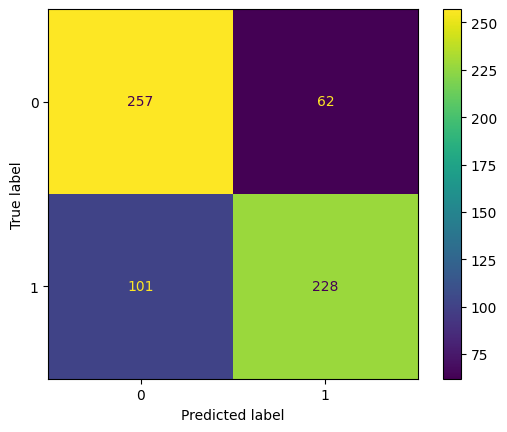

In [ ]:
validation_preds = np.argmax(multilingual_model(validation_sentences), axis=1)
print(classification_report(validation_labels, validation_preds, digits=3))
cm = confusion_matrix(validation_labels, validation_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [ ]:
def count_misclassified_sentences(df: pd.DataFrame, preds: List[int],labels: List[int]) -> Tuple[int, int, int]:
  count_total = 0
  count_en = 0
  count_es = 0

  for i, pred in enumerate(preds):
    if pred != labels[i]:
      count_total += 1
      if df.iloc[i]['lang'] == 'en':
        count_en += 1
      else:
        count_es += 1
  return count_total, count_en, count_es


count_total, count_en, count_es = count_misclassified_sentences(validation_df,validation_preds,validation_labels)
print(f'Total misclassified sentences: {count_total}')
print(f'Misclassified sentences in English: {count_en}')
print(f'Misclassified sentences in Spanish: {count_es}')

Total misclassified sentences: 163
Misclassified sentences in English: 28
Misclassified sentences in Spanish: 135


In [ ]:
decoded_validation = custom_decode(validation_sentences)
plot_unk_stats(validation_preds, validation_labels, decoded_validation)

Statistics of UNK and OOV terms of Custom Model



Sentences         UNK         OOV      
      Total Wrong Total Wrong Total Wrong
0       319    62   735   149   204    37
1       329   101   648   228   212    64

As we can see, the most common words in the misclassified sentences are predominantly Spanish, due to the fact that Spanish sentences are more prevalent than English ones in the validation split. Moreover, we observe a similar pattern to the previous error analysis with the word **'woman'**. Specifically, the Spanish equivalent, **'mujer'**, is the most frequent word in misclassified sentences with label 0 and, while it is the overall most frequent word in label 1, it appears rarely in misclassified sentences for that label.

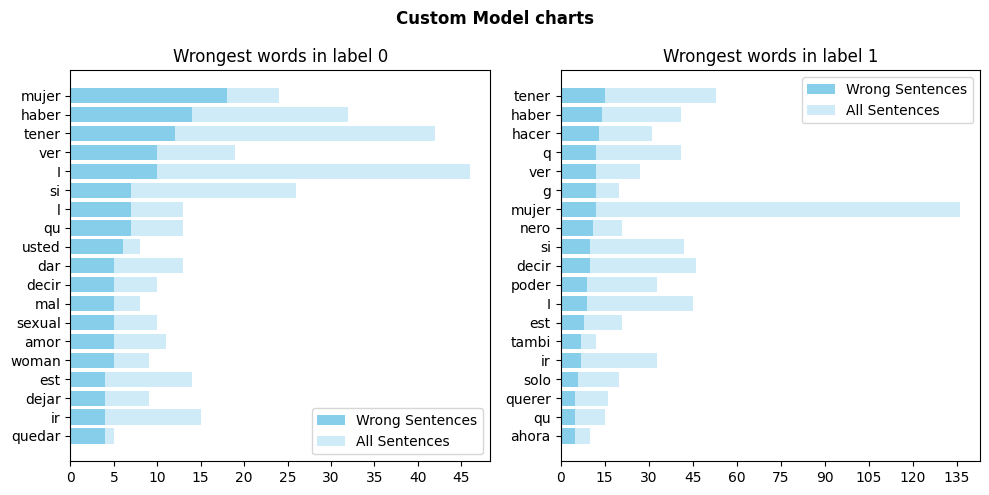

In [ ]:
plot_wrong_word(validation_preds, validation_labels, decoded_validation, 'Custom Model')

### Transformer

Now we will fine-tune the same transformer architecture used earlier in the monolingual section, adopting the same preprocessing procedure and training hyperparameters. As expected, the performance on the validation set dropped slightly, likely because this architecture was mostly pretrained on English text.

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-hate"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, ignore_mismatched_sizes=True
)


In [ ]:
data = datasets.load_dataset(
    "csv",
    data_files={
        "train": "train_multilingual.csv",
        "validation": "validation_multilingual.csv",
    }
)
data = data.map(preprocess_text, batched=True)
data = data.rename_column("hard_label_task1", "label")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

In [ ]:
for name, param in model.named_parameters():
  if 'classifier' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'encoder.layer.9' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

In [ ]:
training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="loss",
    greater_is_better=False,
    seed=best_seed,
    logging_strategy='epoch'
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
validation_info = trainer.predict(data["validation"])
y_pred_transformer, y_true = validation_info.predictions, validation_info.label_ids
validation_metrics = compute_metrics([y_pred_transformer, y_true])
print(
    f'Transformer pre-finetuning validation f1_score {validation_metrics["f1"]:.4f}, accuracy {validation_metrics["acc"]:.4f}'
)

Transformer pre-finetuning validation f1_score 0.3731, accuracy 0.5093


In [ ]:
validation_pred_transformer = np.argmax(softmax(y_pred_transformer,axis=1),axis=1)

count_total, count_en, count_es = count_misclassified_sentences(validation_df,validation_pred_transformer,y_true)
print(f'Total misclassified sentences: {count_total}')
print(f'Misclassified sentences in English: {count_en} out of {len(validation_df[validation_df["lang"] == "en"])}')
print(f'Misclassified sentences in Spanish: {count_es} out of {len(validation_df[validation_df["lang"] == "es"])}')

Total misclassified sentences: 318
Misclassified sentences in English: 58 out of 158
Misclassified sentences in Spanish: 260 out of 490


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,F1,Acc
1,0.524200,0.501840,0.003700,0.760674,0.760802
2,0.455300,0.508893,0.003700,0.760426,0.762346
3,0.422200,0.486943,0.003700,0.808525,0.808642
4,0.379600,0.500273,0.003700,0.795968,0.796296
5,0.346000,0.551903,0.003700,0.817899,0.817901
6,0.311200,0.662030,0.003700,0.802401,0.802469


TrainOutput(global_step=4548, training_loss=0.40640132303497933, metrics={'train_runtime': 489.5987, 'train_samples_per_second': 123.857, 'train_steps_per_second': 15.482, 'total_flos': 1693760974439040.0, 'train_loss': 0.40640132303497933, 'epoch': 6.0})

In [ ]:
validation_info = trainer.predict(data["validation"])
y_pred_transformer, y_true = validation_info.predictions, validation_info.label_ids
validation_metrics = compute_metrics([y_pred_transformer, y_true])
print(
    f'Transformer best validation f1_score {validation_metrics["f1"]:.4f}, accuracy {validation_metrics["acc"]:.4f}'
)

Transformer best validation f1_score 0.8085, accuracy 0.8086


In [ ]:
validation_pred_transformer = np.argmax(softmax(y_pred_transformer,axis=1),axis=1)

count_total, count_en, count_es = count_misclassified_sentences(validation_df,validation_pred_transformer,y_true)
print(f'Total misclassified sentences: {count_total}')
print(f'Misclassified sentences in English: {count_en} out of {len(validation_df[validation_df["lang"] == "en"])}')
print(f'Misclassified sentences in Spanish: {count_es} out of {len(validation_df[validation_df["lang"] == "es"])}')

Total misclassified sentences: 124
Misclassified sentences in English: 17 out of 158
Misclassified sentences in Spanish: 107 out of 490


              precision    recall  f1-score   support

           0      0.812     0.796     0.804       319
           1      0.806     0.821     0.813       329

    accuracy                          0.809       648
   macro avg      0.809     0.808     0.809       648
weighted avg      0.809     0.809     0.809       648



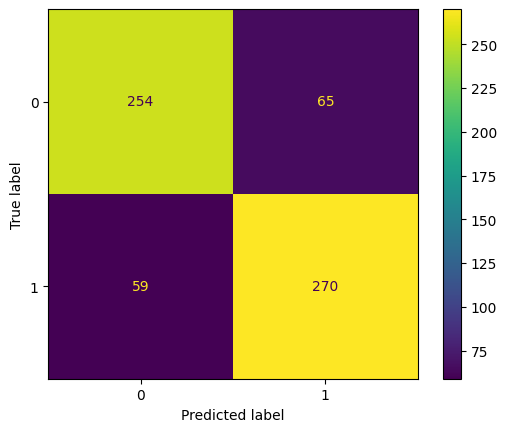

In [ ]:
print(classification_report(validation_labels, validation_pred_transformer, digits=3))
cm = confusion_matrix(validation_labels, validation_pred_transformer)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In the chart below we observe the same pattern previously identified in the custom model regarding the word **'mujer'**. In this case **'mujer'** does not appear in the right chart, indicating that it is rarely misclassified in label 1 sentences.

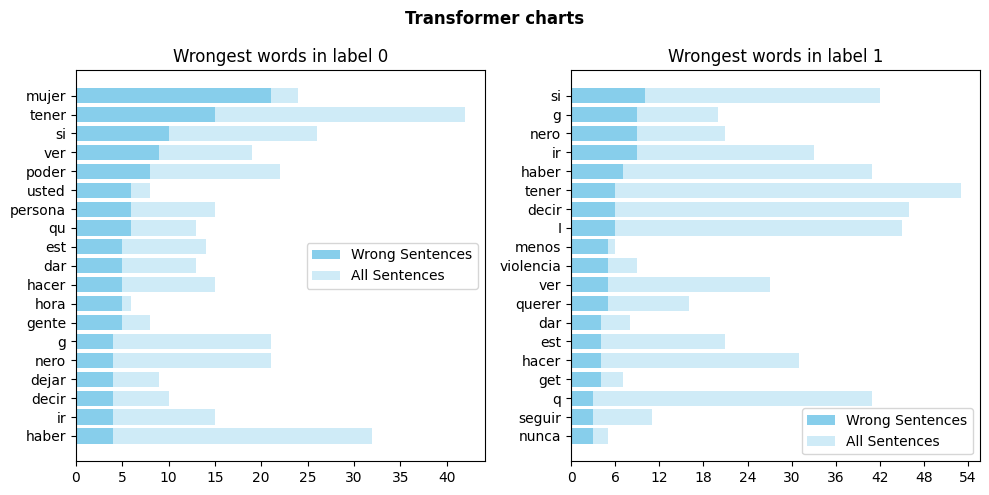

In [ ]:
plot_wrong_word(validation_pred_transformer, validation_labels, decoded_validation, 'Transformer')

### Transformer Multilingual

Now we will compare the previous models with the following one, which is also a Transformer-based architecture but pretrained on **multilingual** corpora. Since this model was originally trained for multiclass classification (3 labels), we replaced and fine-tuned the final classification head to adapt it to our binary classification task.

In [ ]:
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2, ignore_mismatched_sizes=True
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data = datasets.load_dataset(
    "csv",
    data_files={
        "train": "train_multilingual.csv",
        "validation": "validation_multilingual.csv",
    }
)
data = data.map(preprocess_text, batched=True)
data = data.rename_column("hard_label_task1", "label")

Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.472000,0.404488,0.856193,0.856481
2,0.366600,0.599462,0.825397,0.825617
3,0.270100,0.573474,0.836418,0.836420
4,0.156300,1.179024,0.801351,0.804012


TrainOutput(global_step=3032, training_loss=0.31624828731164456, metrics={'train_runtime': 822.6802, 'train_samples_per_second': 73.71, 'train_steps_per_second': 9.214, 'total_flos': 779186946007680.0, 'train_loss': 0.31624828731164456, 'epoch': 4.0})

In [ ]:
validation_info = trainer.predict(data["validation"])
y_pred_transformer, y_true = validation_info.predictions, validation_info.label_ids
validation_metrics = compute_metrics([y_pred_transformer, y_true])
print(
    f'Transformer validation f1_score {validation_metrics["f1"]:.4f}, accuracy {validation_metrics["acc"]:.4f}'
)

Transformer validation f1_score 0.8562, accuracy 0.8565


In [ ]:
validation_pred_transformer = np.argmax(softmax(y_pred_transformer,axis=1),axis=1)

count_total, count_en, count_es = count_misclassified_sentences(validation_df,validation_pred_transformer,y_true)
print(f'Total misclassified sentences: {count_total}')
print(f'Misclassified sentences in English: {count_en} out of {len(validation_df[validation_df["lang"] == "en"])}')
print(f'Misclassified sentences in Spanish: {count_es} out of {len(validation_df[validation_df["lang"] == "es"])}')

Total misclassified sentences: 93
Misclassified sentences in English: 21 out of 158
Misclassified sentences in Spanish: 72 out of 490


              precision    recall  f1-score   support

           0      0.877     0.824     0.850       319
           1      0.839     0.888     0.863       329

    accuracy                          0.856       648
   macro avg      0.858     0.856     0.856       648
weighted avg      0.858     0.856     0.856       648



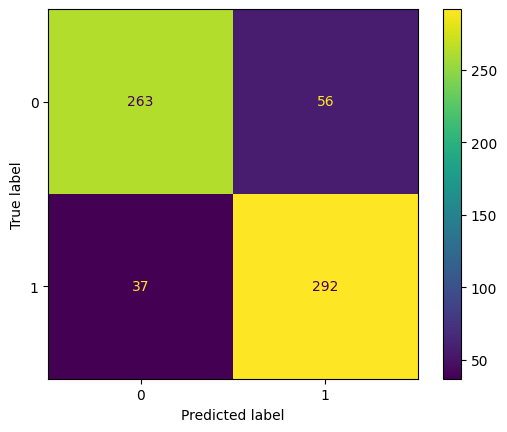

In [ ]:
print(classification_report(validation_labels, validation_pred_transformer, digits=3))
cm = confusion_matrix(validation_labels, validation_pred_transformer)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

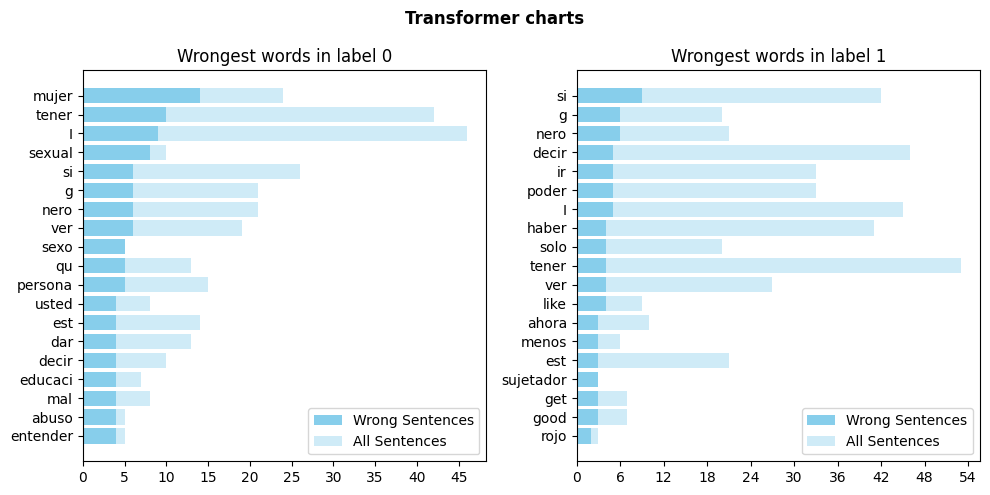

In [ ]:
plot_wrong_word(validation_pred_transformer, validation_labels, decoded_validation, 'Transformer')

As previously shown, the model's performance is **significantly better** than that of the two previous models. Additionally, unlike the other models, the ratio of misclassified sentences is consistent across languages. Lastly we observe the same 'mujer' error pattern in the charts above.

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End